In [243]:
from sklearn.model_selection import KFold
from sklearn.datasets import load_digits
import polars as pl

def fetch_data(df, use_split, rbf=False):
    assert(use_split >= 0 and use_split <= 4)
    # Perform 5-fold cross validation with a deterministic seed
    kf = KFold(n_splits=5, shuffle=True, random_state=2023)
    splits = list(kf.split(df))
    # Indexing the dataframe with an array returns the appropriate splits
    df_train, df_test = df[splits[use_split][0]], df[splits[use_split][1]]

    for col in df_train.columns:
        df_train, df_test = rbf_column(df_train, df_test, col) if rbf else df_train, df_test # Use radial bias function
    return df_train, df_test


def rbf_column(df_train, df_test, col_name):
    std = df_train.get_column(col_name).std()
    low = df_train.get_column(col_name).quantile(0.25)
    middle = df_train.get_column(col_name).quantile(0.5)
    high = df_train.get_column(col_name).quantile(0.75)
    for i, val in enumerate([low, middle, high]):
        df_train = df_train.with_columns((-1.0 * (pl.col(col_name) - val)**2 / (2 * std)**2).exp().alias(f"{col_name}_{i}"))
        df_test = df_test.with_columns((-1.0 * (pl.col(col_name) - val)**2 / (2 * std)**2).exp().alias(f"{col_name}_{i}"))
    return df_train.drop(col_name), df_test.drop(col_name)

def get_x_y(df):
    X, y = df.drop('target'), df.get_column('target')
    X = X.with_columns(pl.lit(1.0).alias('constant')) # extra column for the bias term
    return X.to_numpy(), y.to_numpy()

data = load_digits(n_class=2)
df = pl.DataFrame(data.data)
df = df.with_columns(pl.Series(name='target', values=data.target)) 

df_train, df_test = fetch_data(df, 0)
X_train, y_train = get_x_y(df_train)
X_test, y_test = get_x_y(df_test)
df_train.tail()

column_0,column_1,column_2,column_3,column_4,column_5,column_6,column_7,column_8,column_9,column_10,column_11,column_12,column_13,column_14,column_15,column_16,column_17,column_18,column_19,column_20,column_21,column_22,column_23,column_24,column_25,column_26,column_27,column_28,column_29,column_30,column_31,column_32,column_33,column_34,column_35,column_36,column_37,column_38,column_39,column_40,column_41,column_42,column_43,column_44,column_45,column_46,column_47,column_48,column_49,column_50,column_51,column_52,column_53,column_54,column_55,column_56,column_57,column_58,column_59,column_60,column_61,column_62,column_63,target
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i64
0.0,0.0,4.0,10.0,12.0,7.0,0.0,0.0,0.0,0.0,8.0,16.0,16.0,15.0,0.0,0.0,0.0,0.0,9.0,16.0,16.0,12.0,0.0,0.0,0.0,0.0,7.0,16.0,16.0,9.0,0.0,0.0,0.0,0.0,2.0,14.0,16.0,11.0,1.0,0.0,0.0,0.0,0.0,16.0,16.0,16.0,0.0,0.0,0.0,0.0,2.0,16.0,16.0,12.0,0.0,0.0,0.0,0.0,1.0,9.0,10.0,0.0,0.0,0.0,1
0.0,0.0,4.0,16.0,16.0,8.0,0.0,0.0,0.0,0.0,6.0,16.0,16.0,15.0,1.0,0.0,0.0,0.0,4.0,16.0,16.0,12.0,0.0,0.0,0.0,0.0,3.0,16.0,16.0,15.0,0.0,0.0,0.0,0.0,8.0,16.0,16.0,6.0,0.0,0.0,0.0,1.0,13.0,16.0,16.0,4.0,0.0,0.0,0.0,3.0,16.0,16.0,15.0,2.0,0.0,0.0,0.0,0.0,6.0,12.0,12.0,2.0,0.0,0.0,1
0.0,0.0,5.0,16.0,10.0,0.0,0.0,0.0,0.0,0.0,8.0,16.0,16.0,5.0,0.0,0.0,0.0,0.0,14.0,14.0,1.0,12.0,0.0,0.0,0.0,0.0,15.0,10.0,0.0,7.0,4.0,0.0,0.0,2.0,16.0,7.0,0.0,2.0,9.0,0.0,0.0,2.0,16.0,8.0,0.0,6.0,11.0,0.0,0.0,1.0,12.0,14.0,14.0,16.0,5.0,0.0,0.0,0.0,4.0,15.0,16.0,8.0,1.0,0.0,0
0.0,0.0,6.0,12.0,12.0,6.0,0.0,0.0,0.0,0.0,11.0,16.0,16.0,13.0,0.0,0.0,0.0,0.0,12.0,16.0,16.0,8.0,0.0,0.0,0.0,0.0,8.0,16.0,16.0,12.0,0.0,0.0,0.0,2.0,13.0,16.0,16.0,12.0,0.0,0.0,0.0,1.0,16.0,16.0,16.0,10.0,0.0,0.0,0.0,0.0,16.0,16.0,16.0,8.0,0.0,0.0,0.0,0.0,2.0,11.0,10.0,4.0,0.0,0.0,1
0.0,0.0,6.0,16.0,13.0,11.0,1.0,0.0,0.0,0.0,16.0,15.0,12.0,16.0,1.0,0.0,0.0,3.0,16.0,7.0,0.0,13.0,6.0,0.0,0.0,4.0,16.0,0.0,0.0,10.0,8.0,0.0,0.0,8.0,16.0,0.0,0.0,14.0,6.0,0.0,0.0,5.0,16.0,7.0,9.0,16.0,5.0,0.0,0.0,1.0,15.0,16.0,16.0,16.0,1.0,0.0,0.0,0.0,6.0,16.0,14.0,6.0,0.0,0.0,0


In [244]:
import numpy as np

def sigmoid(x):
    return 1./(1. + np.exp(-x))

def error(x, y, w):
    inside = sigmoid(np.dot(w, x))
    return -(y * np.log(inside) + (1 - y) * np.log(1 - inside))

def error_gradient(x, y, w, lamb):
    # norm = np.abs(w).sum() # causing weird issues
    norm = 1
    return x * (sigmoid(np.dot(w, x)) - y) + lamb * norm

def sgd(X, Y, lr, lamb=0, epochs=1000):
    w = np.zeros_like(X[0])
    err_avg = []

    for _ in range(epochs):
        err = []
        for (x, y) in zip(X, Y):
            w = w - lr * error_gradient(x, y, w, lamb)
            err.append(error(x, y, w))
        err_avg.append(np.mean(err))
    
    return w, err_avg

In [245]:
l = np.logspace(-5, 5) # lambda values to test
l = [0.1, 0.2, 0.3]

def logistic_regression(X, y, lambdas):
    weights, errors = [], []
    for l in lambdas:
        w, err = sgd(X, y, 0.005, l)
        weights.append(w)
        errors.append(err)
    return weights, errors

weights, errors = logistic_regression(X_train, y_train, l)

/var/folders/cx/_phxm6c10d9460chpnq1cnq80000gn/T/ipykernel_56890/2896051258.py:8: RuntimeWarning: divide by zero encountered in log
  return -(y * np.log(inside) + (1 - y) * np.log(1 - inside))
/var/folders/cx/_phxm6c10d9460chpnq1cnq80000gn/T/ipykernel_56890/2896051258.py:8: RuntimeWarning: invalid value encountered in scalar multiply
  return -(y * np.log(inside) + (1 - y) * np.log(1 - inside))
/var/folders/cx/_phxm6c10d9460chpnq1cnq80000gn/T/ipykernel_56890/2896051258.py:4: RuntimeWarning: overflow encountered in exp
  return 1./(1. + np.exp(-x))


In [246]:
from sklearn.linear_model import LogisticRegression

def score(X, y, w):
    preds = np.array([sigmoid(np.dot(x, w)) for x in X])
    score = (np.count_nonzero(preds == y)) / len(y)
    return score

def run_experiment(df, use_split, lambdas, rbf=False):
    df_train, df_test = fetch_data(df, use_split, rbf=rbf)
    X_train, y_train = get_x_y(df_train)
    X_test, y_test = get_x_y(df_test)
    all_weights, _ = logistic_regression(X_train, y_train, lambdas)
    scores = [score(X_test, y_test, w) for w in all_weights]
    return np.array(scores)

def sk_bench(df, use_split, rbf=False):
    df_train, df_test = fetch_data(df, use_split, rbf=rbf)
    X_train, y_train = get_x_y(df_train)
    X_test, y_test = get_x_y(df_test)
    model = LogisticRegression(solver='newton-cholesky', random_state=0).fit(X_train, y_train)
    return model.score(X_test, y_test)

In [247]:
l = [0.1, 0.2, 0.3]
scores = np.stack([run_experiment(df, x, l, rbf=False) for x in range(5)])

print(f'Best: {scores.mean(axis=0).argmax()}')
print(f'Best Score: {scores.mean(axis=0).max()}')
# print(f'Lambda Value: {l[25]}') 

/var/folders/cx/_phxm6c10d9460chpnq1cnq80000gn/T/ipykernel_56890/2896051258.py:8: RuntimeWarning: divide by zero encountered in log
  return -(y * np.log(inside) + (1 - y) * np.log(1 - inside))
/var/folders/cx/_phxm6c10d9460chpnq1cnq80000gn/T/ipykernel_56890/2896051258.py:8: RuntimeWarning: invalid value encountered in scalar multiply
  return -(y * np.log(inside) + (1 - y) * np.log(1 - inside))
/var/folders/cx/_phxm6c10d9460chpnq1cnq80000gn/T/ipykernel_56890/2896051258.py:4: RuntimeWarning: overflow encountered in exp
  return 1./(1. + np.exp(-x))


Best: 1
Best Score: 0.9638888888888889


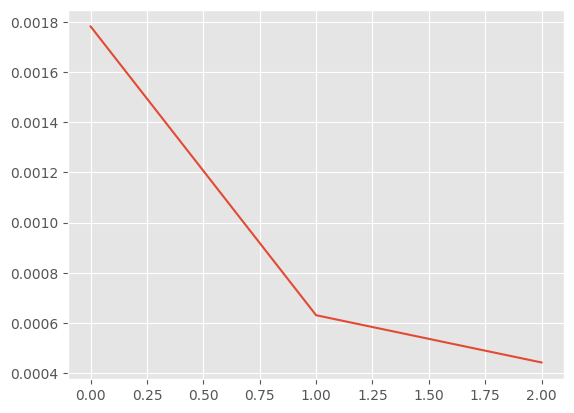

In [248]:
import matplotlib.pyplot as plt

len(errors[0])

plt.plot(np.arange(1000), errors[0])
plt.show()

/var/folders/cx/_phxm6c10d9460chpnq1cnq80000gn/T/ipykernel_56890/2896051258.py:8: RuntimeWarning: divide by zero encountered in log
  return -(y * np.log(inside) + (1 - y) * np.log(1 - inside))
/var/folders/cx/_phxm6c10d9460chpnq1cnq80000gn/T/ipykernel_56890/2896051258.py:8: RuntimeWarning: invalid value encountered in scalar multiply
  return -(y * np.log(inside) + (1 - y) * np.log(1 - inside))
/var/folders/cx/_phxm6c10d9460chpnq1cnq80000gn/T/ipykernel_56890/2896051258.py:4: RuntimeWarning: overflow encountered in exp
  return 1./(1. + np.exp(-x))


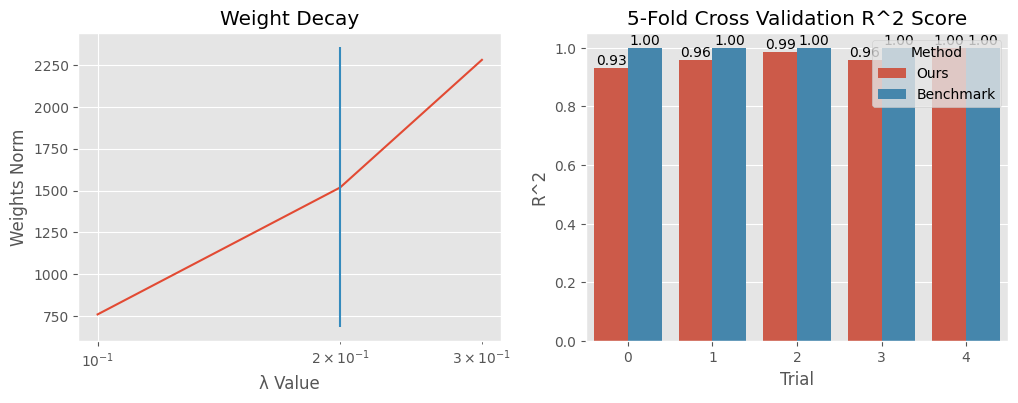

In [249]:
import seaborn
import pandas as pd 
import matplotlib.pyplot as plt

plt.style.use('ggplot')

scores = np.stack([run_experiment(df, x, l, rbf=False) for x in range(5)])

COLORS = seaborn.color_palette()
f, ax = plt.subplots(1, 2, figsize=(12, 4))

ax[0].plot(l, [np.linalg.norm(x) for x in weights], color=COLORS[0])
ax[0].vlines(l[scores.mean(axis=0).argmax()], ymin=ax[0].get_ylim()[0], ymax=ax[0].get_ylim()[1], color=COLORS[1])
ax[0].set_xscale('log')
ax[0].set_ylabel('Weights Norm')
ax[0].set_xlabel('λ Value')
ax[0].set_title('Weight Decay')

our_method = scores.max(axis=1).tolist()
benchmark = [sk_bench(df, x, rbf=False) for x in range(5)]
method = ['Ours' for _ in range(5)] + ['Benchmark' for _ in range(5)]
plot_df = pd.DataFrame.from_dict({'R^2': our_method + benchmark, 'Method': method, 'Trial': list(range(5)) + list(range(5))})
ax[1].set_title('5-Fold Cross Validation R^2 Score')
seaborn.barplot(data=plot_df, x='Trial', y='R^2', hue='Method', ax=ax[1], palette=COLORS)
for container in ax[1].containers:
    ax[1].bar_label(container, fmt="%.2f")

In [250]:
import seaborn
import pandas as pd 
import matplotlib.pyplot as plt

plt.style.use('ggplot')

out = np.stack([run_experiment(df, x, l, rbf=True) for x in range(5)])

COLORS = seaborn.color_palette()
f, ax = plt.subplots(1, 1)

our_method = out.max(axis=1).tolist()
benchmark = [sk_bench(df, x, rbf=True) for x in range(5)]
method = ['Ours' for _ in range(5)] + ['Benchmark' for _ in range(5)]
plot_df = pd.DataFrame.from_dict({'R^2': our_method + benchmark, 'Method': method, 'Trial': list(range(5)) + list(range(5))})
ax.set_title('5-Fold Cross Validation R^2 Score')
seaborn.barplot(data=plot_df, x='Trial', y='R^2', hue='Method', ax=ax, palette=COLORS)
for container in ax.containers:
    ax.bar_label(container, fmt="%.2f")

AttributeError: 'tuple' object has no attribute 'get_column'